# Data Preprocessing

In [ ]:
pip install tensorflow

In [ ]:
pip install keras

In [ ]:
pip install numpy

In [ ]:
pip install pandas

In [ ]:
pip install matplotlib

In [2]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense,Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import numpy as np

In [3]:
dependent_vowel = {
    'ा': 'ā', 
    'ि': 'i', 
    'ी': 'ī', 
    'ु': 'u', 
    'ू': 'ū', 
    'ृ': 'ri', 
    'ॄ': 'rr', 
    'ॅ': 'ĕ', 
    'ॆ': 'e', 
    'े': 'ê', 
    'ै': 'ai', 
    'ॉ': 'ŏ', 
    'ॊ': 'o', 
    'ो': 'ô', 
    'ौ': 'au', 
    '्': '', #lack of a vowel sound
    'ं': 'ṃ',
    'ँ': 'n̐',
    'ः': 'ḥ',
    '़': '', #accounts for regional differences, unsure of exact differences

}
consonant = {
    'क': 'k',
    'ख': 'kh',
    'ग': 'g',
    'घ': 'gh',
    'ङ': 'ṅa',
    'च': 'c',
    'छ': 'ch',
    'ज': 'j',
    'झ': 'jh',
    'ञ': 'ña',
    'ट': 'ṭ',
    'ठ': 'ṭh',
    'ड': 'ḍ',
    'ढ': 'ḍh',
    'ण': 'ṇ',
    'त': 't',
    'थ': 'th',
    'द': 'd',
    'ध': 'dh',
    'न': 'n',
    'प': 'p',
    'फ': 'f',
    'ब': 'b',
    'भ': 'bh',
    'म': 'm',
    'य': 'y',
    'र': 'r',
    'व': 'v',
    'ल': 'l',
    'श': 'sh',
    'ष': 'shh',
    'स': 'ś',
    'ह': 'h',
    'क्ष': 'ksh',
    'त्र': 'tr',
    'ज्ञ': 'gy',
    'ऽ': "'",
    'ळ': 'l',
}
independent_vowel = {
    'अ':'a',
    'आ':'ā',
    'इ':'i',
    'ई':'ī',
    'उ':'u',
    'ऊ':'ū',
    'ए':'a',
    'ऐ':'ai',
    'ओ':'o',
    'औ':'au',
    'अं':'am',
    'ऋ':'ri',
    'ॠ':'rr',
    'ऑ':'aw',
}

In [4]:
def transliterate(word: str, dependent_vowel: dict, consonant: dict, independent_vowel: dict) -> str:
    transliteration = ''
    letter_type = []  

    for char in word:
        if char in dependent_vowel:
            transliteration += dependent_vowel[char]
            letter_type.append('d')
        elif char in consonant:
            transliteration += consonant[char]
            letter_type.append('c')
        else:
            transliteration += independent_vowel[char]
            letter_type.append('i')
        # Check for consecutive consonants
        if len(transliteration) > 1 and len(letter_type) > 1 and letter_type[-1] == 'c' and letter_type[-2] == 'c':
            transliteration = transliteration[:-1] + 'a' + transliteration[-1]
    return transliteration
    

In [5]:
train = pd.read_csv('train.csv')

train = train.drop('english', axis=1)
train = train.drop('Unnamed: 0', axis=1)

transliterations = []
for word in train['hindi']:
    transliterations.append(transliterate(word, dependent_vowel, consonant, independent_vowel))

train['english'] = transliterations
train.head()


,hindi,english
0,अनाधिकृतपणे,anādhikritapaṇê
1,पॉडकास्टर,pŏḍakāśṭar
2,बेयंत,bêyṃt
3,बोझि,bôjhi
4,बहानें,bahānêṃ


In [6]:
train = train.astype(str)
train['hindi'] = train['hindi'].str.strip()
train['english'] = train['english'].str.strip()

sos = '∑' #these can be any characters 
eos = '√'

train['english'] = sos + train['english'] + eos
hindi = train['hindi']
english = train['english']

train.head()

,hindi,english
0,अनाधिकृतपणे,∑anādhikritapaṇê√
1,पॉडकास्टर,∑pŏḍakāśṭar√
2,बेयंत,∑bêyṃt√
3,बोझि,∑bôjhi√
4,बहानें,∑bahānêṃ√


In [7]:
train_hindi_text, val_hindi_text, train_english_text, val_english_text = train_test_split(hindi, english, test_size=0.2, random_state=42)

In [8]:
#creating a sorted list of hindi characters
input_chars = sorted(list(set(''.join(hindi))))
print(len(input_chars))
#creating a sorted list of english characters
target_chars = sorted(list(set(''.join(english))))
print(len(target_chars))

num_encoder_tokens = len(input_chars)
num_decoder_tokens = len(target_chars)

input_char_index = dict((char, i) for i, char in enumerate(input_chars))
print(input_char_index)
target_char_index = dict((char, i) for i, char in enumerate(target_chars))
print(target_char_index)

max_input_len = max([len(text) for text in hindi])
print(max_input_len)
max_target_len = max([len(text) for text in english])
print(max_target_len)


65
41
{'ँ': 0, 'ं': 1, 'ः': 2, 'अ': 3, 'आ': 4, 'इ': 5, 'ई': 6, 'उ': 7, 'ऊ': 8, 'ऋ': 9, 'ए': 10, 'ऐ': 11, 'ऑ': 12, 'ओ': 13, 'औ': 14, 'क': 15, 'ख': 16, 'ग': 17, 'घ': 18, 'ङ': 19, 'च': 20, 'छ': 21, 'ज': 22, 'झ': 23, 'ञ': 24, 'ट': 25, 'ठ': 26, 'ड': 27, 'ढ': 28, 'ण': 29, 'त': 30, 'थ': 31, 'द': 32, 'ध': 33, 'न': 34, 'प': 35, 'फ': 36, 'ब': 37, 'भ': 38, 'म': 39, 'य': 40, 'र': 41, 'ल': 42, 'ळ': 43, 'व': 44, 'श': 45, 'ष': 46, 'स': 47, 'ह': 48, '़': 49, 'ऽ': 50, 'ा': 51, 'ि': 52, 'ी': 53, 'ु': 54, 'ू': 55, 'ृ': 56, 'ॅ': 57, 'े': 58, 'ै': 59, 'ॉ': 60, 'ॊ': 61, 'ो': 62, 'ौ': 63, '्': 64}
{"'": 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'r': 16, 's': 17, 't': 18, 'u': 19, 'v': 20, 'w': 21, 'y': 22, 'ê': 23, 'ñ': 24, 'ô': 25, 'ā': 26, 'ĕ': 27, 'ī': 28, 'ŏ': 29, 'ś': 30, 'ū': 31, '̐': 32, 'ḍ': 33, 'ḥ': 34, 'ṃ': 35, 'ṅ': 36, 'ṇ': 37, 'ṭ': 38, '∑': 39, '√': 40}
26
29


In [9]:
#what does this do exactly
encoder_input_data = np.zeros((len(train_hindi_text), max_input_len, num_encoder_tokens), dtype='float32')
decoder_input_data = np.zeros((len(train_english_text), max_target_len, num_decoder_tokens), dtype='float32')
decoder_target_data = np.zeros((len(train_english_text), max_target_len, num_decoder_tokens), dtype='float32')

for i, (input_text, target_text) in enumerate(zip(train_hindi_text, train_english_text)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_char_index[char]] = 1
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_char_index[char]] = 1
        if t > 0:
            decoder_target_data[i, t - 1, target_char_index[char]] = 1

# Defining The Model

In [10]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(256, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]


decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [11]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Model Training

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and model checkpoint
model_save_filename = "model.keras"
earlystopping_cb = EarlyStopping(
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    patience=20,
    restore_best_weights=True
)
mdlcheckpoint_cb = ModelCheckpoint(
    model_save_filename,
    monitor="val_accuracy",
    mode="max",
    verbose=1,
    save_best_only=True
)

# Print the summary of the model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None, 65)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None, 41)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 256),     │    329,728 │ input_layer[0][0] │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │    305,152 │ input_layer_1[0]… │
│                     │ 256), (None,      │            │ lstm[0][1],       │
│                     │ 256), (None,      │            │ lstm[0][2]        │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None, 41)  │     10,537 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 645,417 (2.46 MB)

 Trainable params: 645,417 (2.46 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=64,
          epochs=50,
          validation_split=0.2, 
          callbacks=[earlystopping_cb, mdlcheckpoint_cb])

Epoch 1/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.0679 - loss: 1.0554
Epoch 1: val_accuracy improved from -inf to 0.11514, saving model to model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 64s 63ms/step - accuracy: 0.0679 - loss: 1.0554 - val_accuracy: 0.1151 - val_loss: 0.8506
Epoch 2/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.1386 - loss: 0.7705
Epoch 2: val_accuracy improved from 0.11514 to 0.21720, saving model to model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 83s 83ms/step - accuracy: 0.1386 - loss: 0.7705 - val_accuracy: 0.2172 - val_loss: 0.5046
Epoch 3/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.2312 - loss: 0.4659
Epoch 3: val_accuracy improved from 0.21720 to 0.27029, saving model to model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 94s 94ms/step - accuracy: 0.2312 - loss: 0.4659 - val_accuracy: 0.2703 - val_loss: 0.3372
Epoch 4/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.2726 - loss: 0.3330
Epoch 4: val_accuracy improved f

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3295 - loss: 0.0758
Epoch 24: val_accuracy did not improve from 0.32861
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 75s 75ms/step - accuracy: 0.3295 - loss: 0.0758 - val_accuracy: 0.3159 - val_loss: 0.1212
Epoch 25/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.3230 - loss: 0.0974
Epoch 25: val_accuracy did not improve from 0.32861
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 86s 86ms/step - accuracy: 0.3230 - loss: 0.0974 - val_accuracy: 0.3223 - val_loss: 0.0985
Epoch 26/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.3209 - loss: 0.1060
Epoch 26: val_accuracy did not improve from 0.32861
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 85s 85ms/step - accuracy: 0.3209 - loss: 0.1060 - val_accuracy: 0.3285 - val_loss: 0.0730
Epoch 27/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3310 - loss: 0.0660
Epoch 27: val_accuracy improved from 0.32861 to 0.32907, saving model to model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 82s 82ms/step - a

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.3336 - loss: 0.0380
Epoch 48: val_accuracy improved from 0.33190 to 0.33231, saving model to model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 99s 99ms/step - accuracy: 0.3336 - loss: 0.0380 - val_accuracy: 0.3323 - val_loss: 0.0403
Epoch 49/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.3326 - loss: 0.0436
Epoch 49: val_accuracy did not improve from 0.33231
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 105s 105ms/step - accuracy: 0.3326 - loss: 0.0437 - val_accuracy: 0.3312 - val_loss: 0.0454
Epoch 50/50
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.3338 - loss: 0.0384
Epoch 50: val_accuracy did not improve from 0.33231
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 99s 99ms/step - accuracy: 0.3338 - loss: 0.0384 - val_accuracy: 0.3320 - val_loss: 0.0408
Restoring model weights from the end of the best epoch: 48.


# Plotting Output

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


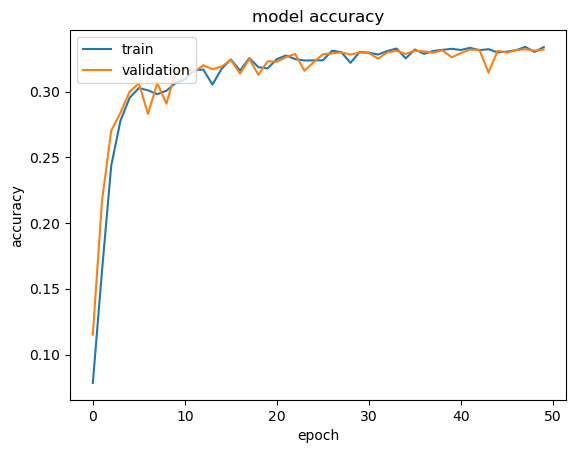

In [14]:
import matplotlib.pyplot as plt

print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

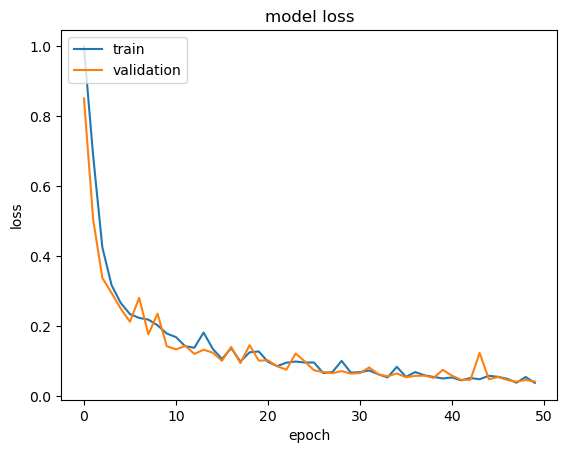

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [31]:
model = load_model('model.keras')

In [32]:
val_encoder_input_data = np.zeros((len(val_hindi_text), max_input_len, num_encoder_tokens), dtype='float32')
val_decoder_input_data = np.zeros((len(val_english_text), max_target_len, num_decoder_tokens), dtype='float32')
val_decoder_target_data = np.zeros((len(val_english_text), max_target_len, num_decoder_tokens), dtype='float32')

In [33]:
for i, (input_text, target_text) in enumerate(zip(val_hindi_text, val_english_text)):
    for t, char in enumerate(input_text):
        val_encoder_input_data[i, t, input_char_index[char]] = 1
    for t, char in enumerate(target_text):
        val_decoder_input_data[i, t, target_char_index[char]] = 1
        if t > 0:
            val_decoder_target_data[i, t - 1, target_char_index[char]] = 1

In [34]:
scores = model.evaluate([val_encoder_input_data, val_decoder_input_data], val_decoder_target_data, verbose=1)
print('Val loss:', scores[0])
print('Val accuracy:', scores[1])

625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.3309 - loss: 0.0402
Val loss: 0.04016752168536186
Val accuracy: 0.33119997382164


In [35]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [36]:
reverse_input_char_index = dict((i, char) for char, i in input_char_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_char_index.items())

In [37]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_char_index['∑']] = 1.0
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = target_chars[sampled_token_index]
        decoded_sentence += sampled_char
        if (sampled_char == '√' or len(decoded_sentence) > max_target_len):
            stop_condition = True
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0
        states_value = [h, c]
    return decoded_sentence

In [38]:
def predict_output(input_text):
    words = input_text.split(' ')
    transliterated_words = []
    for word in words:
        input_seq = np.zeros((1, max_input_len, num_encoder_tokens), dtype='float32')
        for t, char in enumerate(word):
            input_seq[0, t, input_char_index[char]] = 1
        decoded_word = decode_sequence(input_seq)
        transliterated_words.append(decoded_word.rstrip('√'))
    return ' '.join(transliterated_words)

In [48]:
text = 'शब्दावली'
print('Hindi text:',text)
print('Transliterated English text:',predict_output(text))

Hindi text: शब्दावली
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Transliterated English text: shabdāvalī


In [45]:
text = 'क्या है'
print('Hindi text:',text)
print('Transliterated English text:',predict_output(text))
#kya haai

Hindi text: क्या है
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Transliterated English text: kyā hai


In [46]:
text = 'रोशन'
print('Hindi text:',text)
print('Transliterated English text:',predict_output(text))

Hindi text: रोशन
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Transliterated English text: rôshan


In [42]:
text = 'अनुवाद'
print('Hindi text:',text)
print('Transliterated English text:',predict_output(text))

Hindi text: अनुवाद
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Transliterated English text: anuvād


In [49]:
text = 'अनाधिकृतपणे'
print('Hindi text:',text)
print('Transliterated English text:',predict_output(text))

Hindi text: अनाधिकृतपणे
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Transliterated English text: anādhikritapaṇê
